### Imports

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path


from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

# Create dataloaders

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single =  DataLoader(test_dataset, batch_size=1)

### Inputs

In [3]:
pretrained_model = '../saved_models/Carlini/vanilla/model_01.pth'
use_cuda = True

### Model under attack

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        
        
    activations = []             # list to save the activations of the penultimate layer while training on forwardDetect
    mask = torch.zeros(1, 320)   # mask for the forwardMask function for pruning
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
    
    def forwardDetect(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        self.activations.append(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def forwardMask(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)*self.mask
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

        
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 99.0 %


### MASK model
This model has a mask in the forward method. It is used to create Carlini samples for different mask percentages

In [8]:
class MaskClassifier(nn.Module):
    def __init__(self):
        super(MaskClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        
        
    activations = []             # list to save the activations of the penultimate layer while training on forwardDetect
    mask = torch.ones(1, 320)   # mask for the forwardMask function for pruning
    
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)*self.mask.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


        
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model_mask = MaskClassifier().to(device)

# Load pre-trained model
model_mask.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model_mask.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mask.parameters(), lr=0.001)

# Make a classifier wrapper!
mask_classifier = PyTorchClassifier(
    model=model_mask,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = mask_classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
MaskClassifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 99.0 %


In [9]:
def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

In [10]:
test_model(model, test_dataloader)

0.99

## Pruning Conv2d

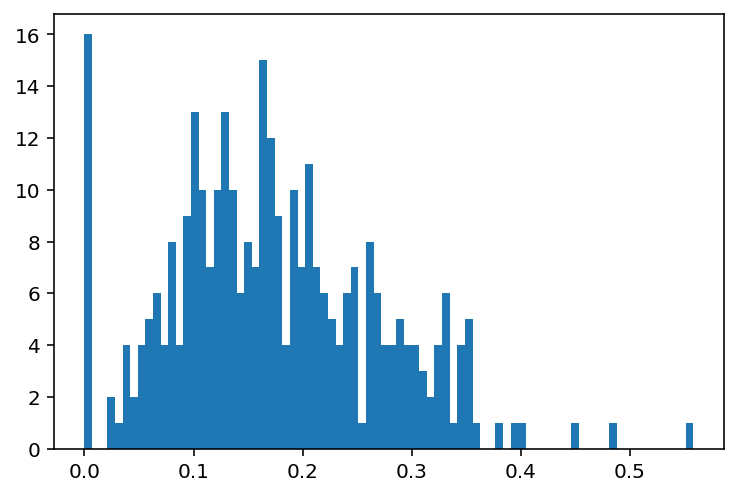

In [11]:
### Get activations in the layer previous to the output layer ###

model.eval() 
with torch.no_grad():
    for data, target in test_dataloader_single:
        output = model.forwardDetect(data.to(device))
activations = model.activations
n = len(activations)
element0 = activations.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations.pop()
    act[e+1,:,:] = elementX

mean_activations = torch.mean(act,dim=[0,1])
ma = mean_activations.numpy()
plt.hist(ma,80)
plt.show()

In [12]:
# save different masks for different percentages

acc = []
masks = dict()

for percentage in range(10):
    s_ma, idx_ma = torch.sort(mean_activations)
    m = torch.ones(mean_activations.size()).to(device)
    nn = mean_activations.size(0)
    
    ind_r = round((percentage/10)*nn)
    m[idx_ma[:ind_r]] = 0.0
    n1 = m.sum()
    model.mask = m
    masks[percentage/10] = model.mask

In [13]:
# evaluate with the new masks

for pg, mask in masks.items():
    model.mask = mask
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader_single:
            output = model.forwardMask(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_dataloader_single.dataset))
        acc.append(acc_test)

    print("Pruned {}  Accuracy: {} %".format(pg, 100*acc_test))

Pruned 0.0  Accuracy: 99.0 %
Pruned 0.1  Accuracy: 98.97 %
Pruned 0.2  Accuracy: 98.74000000000001 %
Pruned 0.3  Accuracy: 98.29 %
Pruned 0.4  Accuracy: 97.48 %
Pruned 0.5  Accuracy: 93.99 %
Pruned 0.6  Accuracy: 92.03 %
Pruned 0.7  Accuracy: 88.42 %
Pruned 0.8  Accuracy: 86.21 %
Pruned 0.9  Accuracy: 66.75 %


## Carlini

In [14]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    start = time.time()
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)
    end = time.time()
#     print(round((end-start)/60, 3), "mins")
    
    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    start = time.time()
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    end = time.time()
#     print(round((end-start)/60, 3), "mins")
    
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

### L2

In [15]:
carlini_prune = dict()
constants = [0.1, 0.5, 1.0, 5, 10]
n = 1000
# Run test for each c and mask PG 
for pg, mask in masks.items():
    print('\n Pruned {}'.format(pg))
    accuracies = []
    distances = []
    results = dict()
    
    model_mask.mask = mask
    
    for init in constants:
        x_test_adv = CarliniL2(mask_classifier, x_test[:n], init_const=init)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        distances.append(L2distance(x_test[:n], x_test_adv))
        
        print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

    results['accuracies'] = accuracies
    results['distances'] = distances
    results['constants'] = constants
    carlini_prune[pg] = results


 Pruned 0.0
c: 0.1  Accuracy: 0.979  Distance: 0.271
c: 0.5  Accuracy: 0.833  Distance: 1.275
c: 1.0  Accuracy: 0.563  Distance: 2.017
c: 5  Accuracy: 0.096  Distance: 3.117
c: 10  Accuracy: 0.062  Distance: 3.46

 Pruned 0.1
c: 0.1  Accuracy: 0.974  Distance: 0.29
c: 0.5  Accuracy: 0.825  Distance: 1.286
c: 1.0  Accuracy: 0.555  Distance: 2.019
c: 5  Accuracy: 0.093  Distance: 3.129
c: 10  Accuracy: 0.052  Distance: 3.462

 Pruned 0.2
c: 0.1  Accuracy: 0.977  Distance: 0.236
c: 0.5  Accuracy: 0.84  Distance: 1.2
c: 1.0  Accuracy: 0.569  Distance: 1.975
c: 5  Accuracy: 0.099  Distance: 3.011
c: 10  Accuracy: 0.058  Distance: 3.346

 Pruned 0.3
c: 0.1  Accuracy: 0.973  Distance: 0.183
c: 0.5  Accuracy: 0.835  Distance: 1.077
c: 1.0  Accuracy: 0.576  Distance: 1.833
c: 5  Accuracy: 0.097  Distance: 2.849
c: 10  Accuracy: 0.062  Distance: 3.157

 Pruned 0.4
c: 0.1  Accuracy: 0.957  Distance: 0.22
c: 0.5  Accuracy: 0.817  Distance: 0.939
c: 1.0  Accuracy: 0.569  Distance: 1.615
c: 5  Accu

### LInf

In [16]:
carlini_inf_prune = dict()
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
n = 1000
# Run test for each epsilon and mask PG 
for pg, mask in masks.items():
    print('\n Pruned {}'.format(pg))
    accuracies = []
    results = dict()
    
    model_mask.mask = mask
    
    for eps in epsilons:
        x_test_adv = CarliniLInf(mask_classifier, x_test[:n], epsilon=eps)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        
        print('eps:', eps, ' Accuracy:', acc)

    results['accuracies'] = accuracies
    results['epsilons'] = epsilons
    carlini_inf_prune[pg] = results


 Pruned 0.0
eps: 0.01  Accuracy: 0.988
eps: 0.1  Accuracy: 0.933
eps: 0.2  Accuracy: 0.777
eps: 0.3  Accuracy: 0.57
eps: 0.4  Accuracy: 0.371
eps: 0.5  Accuracy: 0.184
eps: 0.6  Accuracy: 0.099

 Pruned 0.1
eps: 0.01  Accuracy: 0.987
eps: 0.1  Accuracy: 0.93
eps: 0.2  Accuracy: 0.793
eps: 0.3  Accuracy: 0.575
eps: 0.4  Accuracy: 0.359
eps: 0.5  Accuracy: 0.19
eps: 0.6  Accuracy: 0.106

 Pruned 0.2
eps: 0.01  Accuracy: 0.989
eps: 0.1  Accuracy: 0.921
eps: 0.2  Accuracy: 0.776
eps: 0.3  Accuracy: 0.55
eps: 0.4  Accuracy: 0.331
eps: 0.5  Accuracy: 0.169
eps: 0.6  Accuracy: 0.082

 Pruned 0.3
eps: 0.01  Accuracy: 0.982
eps: 0.1  Accuracy: 0.904
eps: 0.2  Accuracy: 0.763
eps: 0.3  Accuracy: 0.505
eps: 0.4  Accuracy: 0.307
eps: 0.5  Accuracy: 0.144
eps: 0.6  Accuracy: 0.086

 Pruned 0.4
eps: 0.01  Accuracy: 0.964
eps: 0.1  Accuracy: 0.883
eps: 0.2  Accuracy: 0.719
eps: 0.3  Accuracy: 0.476
eps: 0.4  Accuracy: 0.26
eps: 0.5  Accuracy: 0.126
eps: 0.6  Accuracy: 0.075

 Pruned 0.5
eps: 0.01  A

## Results

### L2

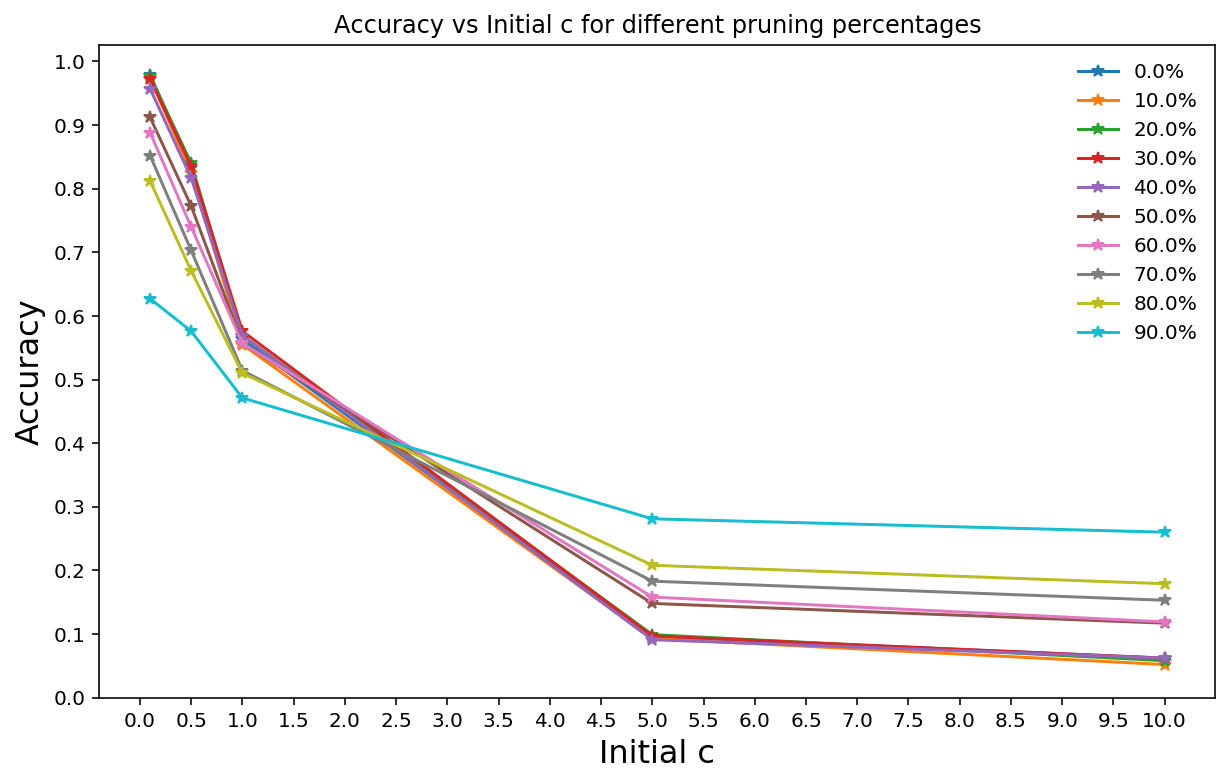

In [21]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))

for pg, results in carlini_prune.items():
    plt.plot(results['constants'], results['accuracies'], "*-", label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 10.5, step=0.5))
plt.title("Accuracy vs Initial c for different pruning percentages")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

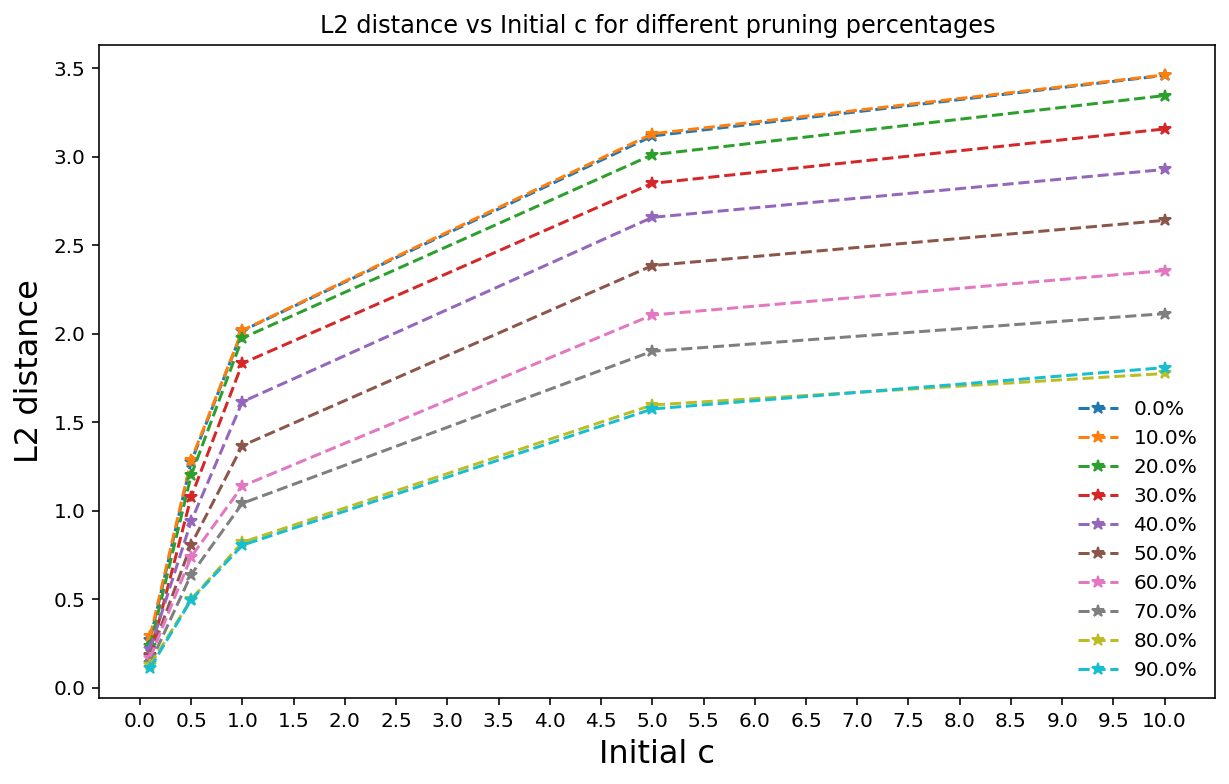

In [18]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))

for pg, results in carlini_prune.items():
    plt.plot(results['constants'], results['distances'], "*--", label=str(pg*100)+'%')

plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 10.5, step=0.5))
plt.title("L2 distance vs Initial c for different pruning percentages")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

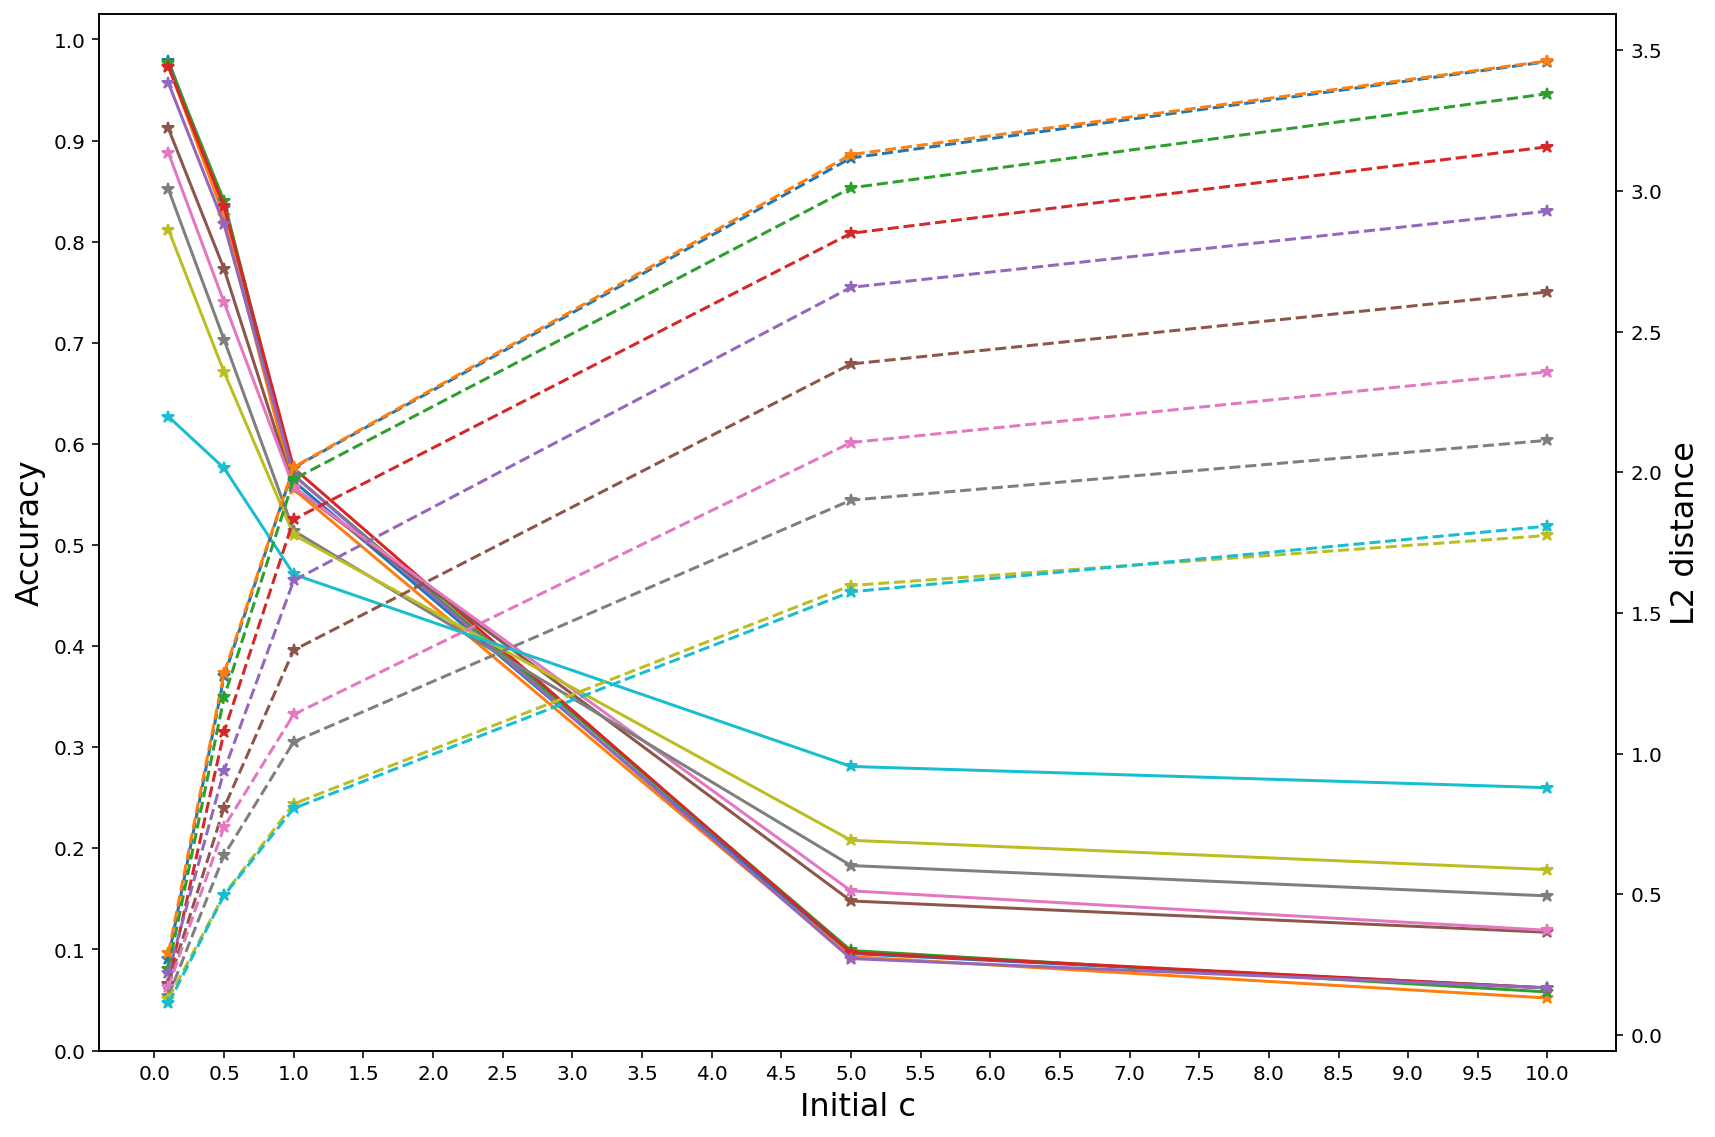

In [19]:
fig, ax1 = plt.subplots(figsize=(12,8))

ax1.set_xlabel('Initial c',fontsize=16)
ax1.set_ylabel('Accuracy',fontsize=16)
for pg, results in carlini_prune.items():
    ax1.plot(results['constants'], results['accuracies'], "*-", label=str(pg*100)+'%')
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_xticks(np.arange(0, 10.5, step=0.5))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('L2 distance',fontsize=16)
for pg, results in carlini_prune.items():
    plt.plot(results['constants'], results['distances'], "*--", label=str(pg*100)+'%')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [254]:
from collections import defaultdict
distance_per_c = defaultdict(list)
for pg, results in carlini_prune.items():
    for i in range(5):
        distance_per_c[results['constants'][i]].append(results['distances'][i])

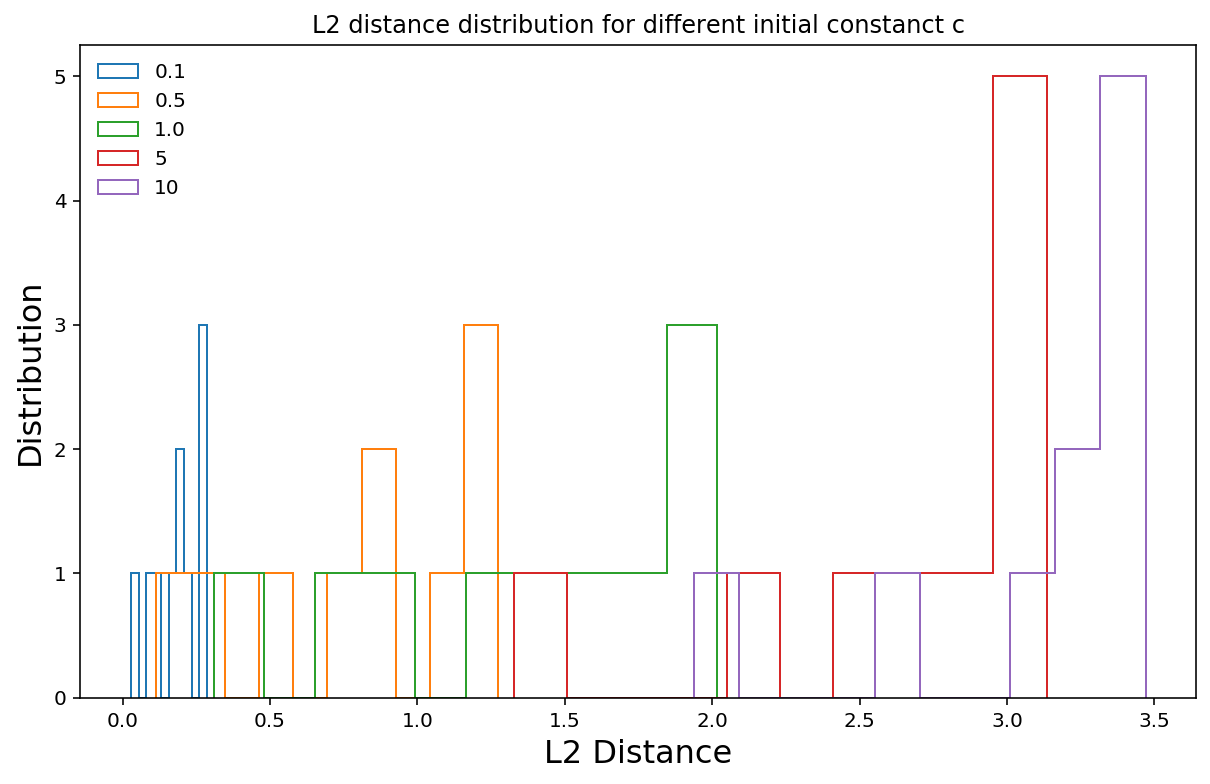

In [271]:
plt.figure(figsize=(10,6))
for c, dist in distance_per_c.items():
    plt.hist(dist, histtype='step', label=c)

plt.title("L2 distance distribution for different initial constanct c")
plt.xlabel("L2 Distance",fontsize=16)
plt.ylabel("Distribution",fontsize=16)
plt.legend(loc='upper left', frameon=False)
plt.show()

### LInf

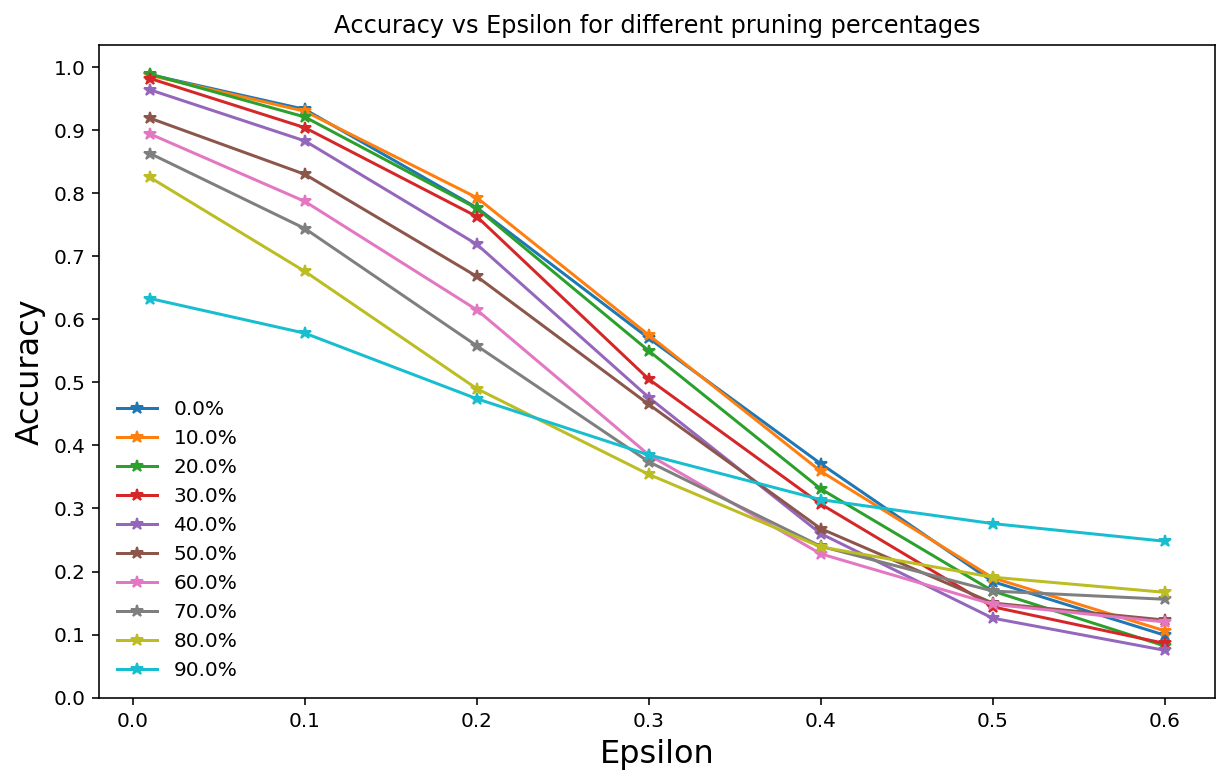

In [20]:
# plot the pruned accuracies vs epsilon 

plt.figure(figsize=(10,6))

for pg, results in carlini_inf_prune.items():
    plt.plot(results['epsilons'], results['accuracies'], "*-", label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.61, step=0.1))
plt.title("Accuracy vs Epsilon for different pruning percentages")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='lower left', frameon=False)
plt.show()